In [1]:
%matplotlib inline

In [2]:
import pandas as pd
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt

# Load in the clean `.tsv` file


In [3]:
df = pd.read_csv('../Data/host_genomes/562.clean.tsv', sep='\t', index_col=0)
df.head()

,genome_id,source,type,start,stop,idk,strand,trash,qualifiers,coding_sequence,upstream_sequence,RBS_energy,RBS_energy_upstream,iCUB,GC_cds,GC_upstream,locus_tag
0,NC_000913.3,RefSeq,CDS,190,255,.,+,0,ID=cds-NP_414542.1;Parent=gene-b0001;Dbxref=Un...,ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCA...,ATTACAGAGTACACAACATCC,-0.17,-2.46,32.046035,0.515152,0.380952,b0001
1,NC_000913.3,RefSeq,CDS,337,2799,.,+,0,ID=cds-NP_414543.1;Parent=gene-b0002;Dbxref=Un...,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,AAAGGTAACGAGGTAACAACC,-5.42,-2.52,55.949262,0.530654,0.428571,b0002
2,NC_000913.3,RefSeq,CDS,2801,3733,.,+,0,ID=cds-NP_414544.1;Parent=gene-b0003;Dbxref=Un...,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,CATGGAAGTTAGGAGTCTGAC,-6.51,-3.60,56.062386,0.562701,0.476190,b0003
3,NC_000913.3,RefSeq,CDS,3734,5020,.,+,0,ID=cds-NP_414545.1;Parent=gene-b0004;Dbxref=Un...,ATGAAACTCTACAATCTGAAAGATCACAACGAGCAGGTCAGCTTTG...,GCACGAGTACTGGAAAACTAA,-3.40,-2.54,53.052776,0.528361,0.428571,b0004
4,NC_000913.3,RefSeq,CDS,5234,5530,.,+,0,ID=cds-NP_414546.1;Parent=gene-b0005;Dbxref=Un...,GTGAAAAAGATGCAATCTATCGTACTCGCACTTTCCCTGGTTCTGG...,CAATGATAAAAGGAGTAACCT,-6.51,-0.33,50.705530,0.538721,0.333333,b0005


**Some later data will require the "Gene" merge so make it a dedicated column and filter any duplicates**

In [4]:
print(df.shape)
df['Gene'] = df['qualifiers'].str.split(';gene=', n=1, expand=True)[1]\
                                .str.split(';', n=1, expand=True)[0]
df = df.drop_duplicates('Gene', keep=False)
print(df.shape)

(4060, 17)
(4060, 18)


# Add in knowledge of protein abundances and join the dataframes

In [5]:
prot_df = pd.read_csv('../Data/562_associated_data/511145-WHOLE_ORGANISM-integrated.txt',\
                      sep='\t', comment='#', header=None)
print(prot_df.shape)
prot_df.head()

(4096, 3)


,0,1,2
0,6881590,511145.b0789,1.10
1,6882118,511145.b1341,25.20
2,6882232,511145.b1475,2.97
3,6883902,511145.b3309,2603.00
4,6881517,511145.b0708,1.45


**Add in a dedicated `locus_tag` column by splitting column 1**

In [6]:
prot_df['locus_tag']= prot_df[1].str.split(".", n = 1, expand = True)[1]
assert prot_df['locus_tag'].value_counts().max() == 1
prot_df.head()

,0,1,2,locus_tag
0,6881590,511145.b0789,1.10,b0789
1,6882118,511145.b1341,25.20,b1341
2,6882232,511145.b1475,2.97,b1475
3,6883902,511145.b3309,2603.00,b3309
4,6881517,511145.b0708,1.45,b0708


**Rename the columns and drop the unnecessary bits**

In [7]:
prot_df = prot_df.drop([0, 1], axis=1)
prot_df.columns = ['prot_abundance', 'locus_tag']
prot_df.head()

,prot_abundance,locus_tag
0,1.10,b0789
1,25.20,b1341
2,2.97,b1475
3,2603.00,b3309
4,1.45,b0708


**Merge with the original dataframe on `locus_tag`**

In [8]:
combined_df = df.merge(prot_df, on='locus_tag', how='left')
combined_df.shape

(4060, 19)

In [9]:
combined_df.head()

,genome_id,source,type,start,stop,idk,strand,trash,qualifiers,coding_sequence,upstream_sequence,RBS_energy,RBS_energy_upstream,iCUB,GC_cds,GC_upstream,locus_tag,Gene,prot_abundance
0,NC_000913.3,RefSeq,CDS,190,255,.,+,0,ID=cds-NP_414542.1;Parent=gene-b0001;Dbxref=Un...,ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCA...,ATTACAGAGTACACAACATCC,-0.17,-2.46,32.046035,0.515152,0.380952,b0001,thrL,0.0
1,NC_000913.3,RefSeq,CDS,337,2799,.,+,0,ID=cds-NP_414543.1;Parent=gene-b0002;Dbxref=Un...,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,AAAGGTAACGAGGTAACAACC,-5.42,-2.52,55.949262,0.530654,0.428571,b0002,thrA,317.0
2,NC_000913.3,RefSeq,CDS,2801,3733,.,+,0,ID=cds-NP_414544.1;Parent=gene-b0003;Dbxref=Un...,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,CATGGAAGTTAGGAGTCTGAC,-6.51,-3.60,56.062386,0.562701,0.476190,b0003,thrB,76.3
3,NC_000913.3,RefSeq,CDS,3734,5020,.,+,0,ID=cds-NP_414545.1;Parent=gene-b0004;Dbxref=Un...,ATGAAACTCTACAATCTGAAAGATCACAACGAGCAGGTCAGCTTTG...,GCACGAGTACTGGAAAACTAA,-3.40,-2.54,53.052776,0.528361,0.428571,b0004,thrC,530.0
4,NC_000913.3,RefSeq,CDS,5234,5530,.,+,0,ID=cds-NP_414546.1;Parent=gene-b0005;Dbxref=Un...,GTGAAAAAGATGCAATCTATCGTACTCGCACTTTCCCTGGTTCTGG...,CAATGATAAAAGGAGTAACCT,-6.51,-0.33,50.705530,0.538721,0.333333,b0005,yaaX,0.0


## Exploration of the relationship between some variables

In [38]:
temp_df = combined_df[combined_df['prot_abundance'].isnull()==False] ###Remove null protein abundance
temp_df = temp_df[temp_df['prot_abundance']!=0] ###Remove zero protein abundance
print(temp_df.shape)

(3576, 21)


RBS energy vs Protein abundance: SpearmanrResult(correlation=-0.09656509677974909, pvalue=7.205333673121545e-09)
iCUB vs Protein abundance: SpearmanrResult(correlation=-0.4543765359014608, pvalue=9.973746903965468e-182)
RBS energy vs iCUB: SpearmanrResult(correlation=0.13332111881329892, pvalue=1.1895158949069418e-15)


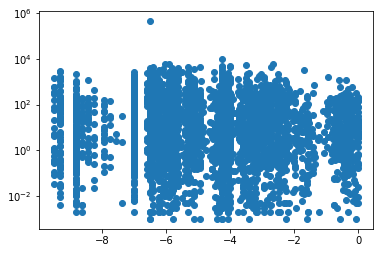

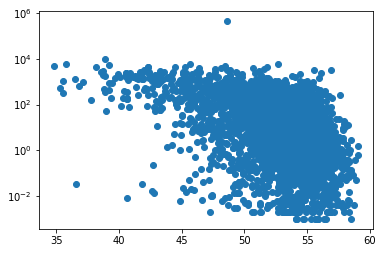

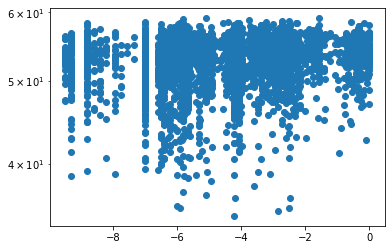

In [40]:
metric = 'RBS_energy'

fig, ax = plt.subplots()
ax.semilogy(temp_df[metric], temp_df['prot_abundance'], 'o')
print('RBS energy vs Protein abundance:',\
      stats.spearmanr(temp_df[metric], temp_df['prot_abundance']))

fig, ax = plt.subplots()
ax.semilogy(temp_df['iCUB'], temp_df['prot_abundance'], 'o')
print('iCUB vs Protein abundance:',\
      stats.spearmanr(temp_df['iCUB'], temp_df['prot_abundance']))

fig, ax = plt.subplots()
ax.semilogy(temp_df[metric], temp_df['iCUB'], 'o')
print('RBS energy vs iCUB:',\
      stats.spearmanr(temp_df[metric], temp_df['iCUB']))

In [50]:
metric = 'RBS_energy'
percentile = 90
percentile_thresh = np.percentile(temp_df['prot_abundance'], percentile)
top = temp_df[temp_df['prot_abundance']>percentile_thresh][metric].mean()

print('Mean RBS energy:', temp_df[metric].mean())
print('Highest {}% protein abundance RBS energy (abundance threshold): {} ({})'.format(100-percentile,\
                                                                                  top,\
                                                                                  percentile_thresh))

Mean RBS energy: -4.662335011185693
Highest 10% protein abundance RBS energy (abundance threshold): -5.4224581005586545 (367.5)


# Add in knowledge of essential genes (and join)

**First, using annotated essential genes from: https://mbio.asm.org/content/9/1/e02096-17**

In [51]:
essential_df = pd.read_csv('../Data/562_associated_data/ecoli_essential.txt', sep='\t')
# essential_df = essential_df[(essential_df['Essential']==True)] #Essential genes
# essential_df = essential_df[(essential_df['Non-essential']==True)] #Non-essential genes
print(essential_df.shape)
essential_df.head()

(4313, 6)


,Gene,Insertion Index Score,Log Likelihood Ratio,Essential,Non-essential,Unclear
0,thrL,0.393939,31.431059,False,True,False
1,thrA,0.219245,17.200782,False,True,False
2,thrB,0.265809,21.234549,False,True,False
3,thrC,0.205905,15.994924,False,True,False
4,yaaX,0.225589,17.765507,False,True,False


In [52]:
essential_df['essentiality_a'] = ''
indices = essential_df[essential_df['Essential']==True].index
essential_df.loc[indices, 'essentiality_a'] = 'Essential'
indices = essential_df[essential_df['Non-essential']==True].index
essential_df.loc[indices, 'essentiality_a'] = 'Non-essential'
indices = essential_df[essential_df['Unclear']==True].index
essential_df.loc[indices, 'essentiality_a'] = 'Unclear'
essential_df.head()

,Gene,Insertion Index Score,Log Likelihood Ratio,Essential,Non-essential,Unclear,essentiality_a
0,thrL,0.393939,31.431059,False,True,False,Non-essential
1,thrA,0.219245,17.200782,False,True,False,Non-essential
2,thrB,0.265809,21.234549,False,True,False,Non-essential
3,thrC,0.205905,15.994924,False,True,False,Non-essential
4,yaaX,0.225589,17.765507,False,True,False,Non-essential


In [53]:
essential_df['essentiality_a'].value_counts()

Non-essential    3793
Essential         358
Unclear           162
Name: essentiality_a, dtype: int64

**Drop the unnecessary bits**

In [54]:
essential_df = essential_df.drop(set(essential_df.columns)-set(['Gene', 'essentiality_a']), axis=1)
essential_df.head()

,Gene,essentiality_a
0,thrL,Non-essential
1,thrA,Non-essential
2,thrB,Non-essential
3,thrC,Non-essential
4,yaaX,Non-essential


In [55]:
combined_df = combined_df.merge(essential_df, on="Gene", how='left')
print(combined_df.shape)
combined_df.head()

(4060, 23)


,genome_id,source,type,start,stop,idk,strand,trash,qualifiers,coding_sequence,...,iCUB,GC_cds,GC_upstream,locus_tag,Gene,prot_abundance,essentiality_a_x,essentiality_b,essentiality_a_y,essentiality_a
0,NC_000913.3,RefSeq,CDS,190,255,.,+,0,ID=cds-NP_414542.1;Parent=gene-b0001;Dbxref=Un...,ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCA...,...,32.046035,0.515152,0.380952,b0001,thrL,0.0,Non-essential,Non-essential,Non-essential,Non-essential
1,NC_000913.3,RefSeq,CDS,337,2799,.,+,0,ID=cds-NP_414543.1;Parent=gene-b0002;Dbxref=Un...,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,...,55.949262,0.530654,0.428571,b0002,thrA,317.0,Non-essential,Non-essential,Non-essential,Non-essential
2,NC_000913.3,RefSeq,CDS,2801,3733,.,+,0,ID=cds-NP_414544.1;Parent=gene-b0003;Dbxref=Un...,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,...,56.062386,0.562701,0.476190,b0003,thrB,76.3,Non-essential,Non-essential,Non-essential,Non-essential
3,NC_000913.3,RefSeq,CDS,3734,5020,.,+,0,ID=cds-NP_414545.1;Parent=gene-b0004;Dbxref=Un...,ATGAAACTCTACAATCTGAAAGATCACAACGAGCAGGTCAGCTTTG...,...,53.052776,0.528361,0.428571,b0004,thrC,530.0,Non-essential,Non-essential,Non-essential,Non-essential
4,NC_000913.3,RefSeq,CDS,5234,5530,.,+,0,ID=cds-NP_414546.1;Parent=gene-b0005;Dbxref=Un...,GTGAAAAAGATGCAATCTATCGTACTCGCACTTTCCCTGGTTCTGG...,...,50.705530,0.538721,0.333333,b0005,yaaX,0.0,Non-essential,Non-essential,Non-essential,Non-essential


## And explore a bit

In [56]:
metric = 'RBS_energy'

temp_df = combined_df[combined_df['essentiality_a'] == 'Essential']
print()
print('Essential:', temp_df.shape[0])
print('RBS energy:', temp_df[metric].mean())
print('Protein abundance:', temp_df['prot_abundance'].mean())
print()

temp_df = combined_df[combined_df['essentiality_a'] != 'Non-essential']
print('Essential+unclear:', temp_df.shape[0])
print('RBS energy:', temp_df[metric].mean())
print('Protein abundance:', temp_df['prot_abundance'].mean())
print()

temp_df = combined_df[combined_df['essentiality_a'] == 'Non-essential']
print('Non-essential:', temp_df.shape[0])
print('RBS energy:', temp_df[metric].mean())
print('Protein abundance:', temp_df['prot_abundance'].mean())
print()


Essential: 343
RBS energy: -4.24723032069971
Protein abundance: 513.534886567164

Essential+unclear: 736
RBS energy: -4.133396739130424
Protein abundance: 339.1125828220859

Non-essential: 3324
RBS energy: -4.717141997593266
Protein abundance: 239.1826741746376



# Essential genes take 2

**Double check using annotated essential gene from: https://www.nature.com/articles/s41586-018-0124-0**

In [60]:
essential_df = pd.read_csv('../Data/562_associated_data/ecoli_essential_Price.txt', sep='\t', skiprows=13)
print(essential_df.shape)
essential_df.head()

(324, 19)


,organism,orgId,locusId,sysName,locus_tag,protein_id,uniprotId,scaffoldId,begin,end,strand,name,desc,GC,nReads,normreads,nPosCentral,dens,geneClass
0,Escherichia coli BW25113,Keio,14168,b0023,BW25113_RS00110,WP_001274021.1,sp|P0A7U7|RS20_ECOLI,7023,20815,21078,-,rpsT,30S ribosomal protein S20 (NCBI),0.4659,0,0.000,0,0.0,Arole
1,Escherichia coli BW25113,Keio,14170,b0025,BW25113_RS00120,WP_000767329.1,sp|P0AG40|RIBF_ECOLI,7023,21407,22348,+,ribF,hypothetical protein (NCBI),0.5361,201,0.056,0,0.0,Arole
2,Escherichia coli BW25113,Keio,14171,b0026,BW25113_RS00125,WP_001286857.1,sp|P00956|SYI_ECOLI,7023,22391,25207,+,ileS,isoleucyl-tRNA synthetase (NCBI),0.5577,0,0.000,0,0.0,Arole
3,Escherichia coli BW25113,Keio,14172,b0027,BW25113_RS00130,WP_000083372.1,sp|P00804|LSPA_ECOLI,7023,25207,25701,+,lspA,signal peptidase II (NCBI),0.5354,0,0.000,0,0.0,Arole
4,Escherichia coli BW25113,Keio,14174,b0029,BW25113_RS00140,WP_001166395.1,sp|P62623|ISPH_ECOLI,7023,26277,27227,+,ispH,4-hydroxy-3-methylbut-2-enyl diphosphate reduc...,0.5510,0,0.000,0,0.0,Bspecific


**Drop the unnecessary bits**

In [61]:
essential_df['essentiality_b'] = 'Essential'
essential_df = essential_df.drop(set(essential_df.columns) - set(['sysName', 'essentiality_b']), axis=1)
essential_df.columns = ['locus_tag', 'essentiality_b']
essential_df.head()

,locus_tag,essentiality_b
0,b0023,Essential
1,b0025,Essential
2,b0026,Essential
3,b0027,Essential
4,b0029,Essential


**Merge with my now growing dataframe**

In [62]:
combined_df = combined_df.merge(essential_df, on='locus_tag', how='left')
print(combined_df.shape)
indices = combined_df[combined_df['essentiality_b']!='Essential'].index
combined_df.loc[indices, 'essentiality_b'] = 'Non-essential'
combined_df.head()

(4060, 25)


,genome_id,source,type,start,stop,idk,strand,trash,qualifiers,coding_sequence,...,GC_upstream,locus_tag,Gene,prot_abundance,essentiality_a_x,essentiality_b_x,essentiality_a_y,essentiality_a,essentiality_b_y,essentiality_b
0,NC_000913.3,RefSeq,CDS,190,255,.,+,0,ID=cds-NP_414542.1;Parent=gene-b0001;Dbxref=Un...,ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCA...,...,0.380952,b0001,thrL,0.0,Non-essential,Non-essential,Non-essential,Non-essential,NaN,Non-essential
1,NC_000913.3,RefSeq,CDS,337,2799,.,+,0,ID=cds-NP_414543.1;Parent=gene-b0002;Dbxref=Un...,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,...,0.428571,b0002,thrA,317.0,Non-essential,Non-essential,Non-essential,Non-essential,NaN,Non-essential
2,NC_000913.3,RefSeq,CDS,2801,3733,.,+,0,ID=cds-NP_414544.1;Parent=gene-b0003;Dbxref=Un...,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,...,0.476190,b0003,thrB,76.3,Non-essential,Non-essential,Non-essential,Non-essential,NaN,Non-essential
3,NC_000913.3,RefSeq,CDS,3734,5020,.,+,0,ID=cds-NP_414545.1;Parent=gene-b0004;Dbxref=Un...,ATGAAACTCTACAATCTGAAAGATCACAACGAGCAGGTCAGCTTTG...,...,0.428571,b0004,thrC,530.0,Non-essential,Non-essential,Non-essential,Non-essential,NaN,Non-essential
4,NC_000913.3,RefSeq,CDS,5234,5530,.,+,0,ID=cds-NP_414546.1;Parent=gene-b0005;Dbxref=Un...,GTGAAAAAGATGCAATCTATCGTACTCGCACTTTCCCTGGTTCTGG...,...,0.333333,b0005,yaaX,0.0,Non-essential,Non-essential,Non-essential,Non-essential,NaN,Non-essential


## Exploration

In [63]:
metric = 'RBS_energy'
temp_df = combined_df[combined_df['essentiality_b'] == 'Essential']
print()
print('Essential:', temp_df.shape[0])
print('RBS energy:', temp_df[metric].mean())
print('Protein abundance:', temp_df['prot_abundance'].mean())
print()

temp_df = combined_df[combined_df['essentiality_b'] == 'Non-essential']
print('Non-essential:', temp_df.shape[0])
print('RBS energy:', temp_df[metric].mean())
print('Protein abundance:', temp_df['prot_abundance'].mean())
print()


Essential: 317
RBS energy: -4.282050473186121
Protein abundance: 429.6606740506327

Non-essential: 3743
RBS energy: -4.639206518835171
Protein abundance: 240.57022029633782



In [64]:
metric = 'RBS_energy'
temp_df = combined_df[(combined_df['essentiality_a']=='Essential') |\
                      (combined_df['essentiality_b']=='Essential')]
print('**When either method says a gene is essential**')
print('Essential:', temp_df.shape[0])
print('RBS energy:', temp_df[metric].mean())
print('Protein abundance:', temp_df['prot_abundance'].mean())
print()
temp_df = combined_df[(combined_df['essentiality_a']=='Essential') &\
                      (combined_df['essentiality_b']=='Essential')]
print('**When both methods say that a gene is essential**')
print('Essential:', temp_df.shape[0])
print('RBS energy:', temp_df[metric].mean())
print('Protein abundance:', temp_df['prot_abundance'].mean())
print()

**When either method says a gene is essential**
Essential: 391
RBS energy: -4.314143222506392
Protein abundance: 459.29647780678846

**When both methods say that a gene is essential**
Essential: 269
RBS energy: -4.19100371747212
Protein abundance: 492.150779850746



# Manuscript quality figures 

In [65]:
virus_df = pd.read_csv('../Data/562_rep_viruses/3437.clean.tsv', sep='\t', index_col=0)
print(virus_df.shape)
virus_df.head()

(65, 17)


,genome_id,source,type,start,stop,idk,strand,trash,qualifiers,coding_sequence,upstream_sequence,RBS_energy,RBS_energy_upstream,iCUB,GC_cds,GC_upstream,viral_id
0,CP016497.1__5178720__3346493__3396605|0,Prodigal_v2.6.3,CDS,3,1040,119.0,-,0,ID=125_1;partial=10;start_type=ATG;rbs_motif=G...,ATGGCTACATCGACAGTAATTCCTGATGACATCAAAACGCTAAAAT...,GGCTGGATGTGAGGAAGAAAA,-5.68,-3.42,55.639792,0.446050,0.476190,125_1
1,CP016497.1__5178720__3346493__3396605|0,Prodigal_v2.6.3,CDS,1050,1331,42.3,-,0,ID=125_2;partial=00;start_type=ATG;rbs_motif=G...,ATGAAAGATTTAACACTCAAATTTGCCGACAGGGCCGACTTTTCGG...,TCAGGTGGGGGAGTCAATCTA,-6.51,-5.18,49.905375,0.421986,0.523810,125_2
2,CP016497.1__5178720__3346493__3396605|0,Prodigal_v2.6.3,CDS,1331,3706,212.5,-,0,ID=125_3;partial=00;start_type=ATG;rbs_motif=G...,ATGGCAGCAGTAAAAATCTCAGGTGTGCTGAAAGATGGTGCGGGAA...,GGGCTTTTTTGTGGAGTGGAT,-5.91,-2.85,57.682051,0.489899,0.476190,125_3
3,CP016497.1__5178720__3346493__3396605|0,Prodigal_v2.6.3,CDS,3771,4370,74.9,-,0,ID=125_4;partial=00;start_type=ATG;rbs_motif=G...,ATGCGTAAATTATGTGCTGTTATTCTGTCCACAGTAGTCTGGCTGG...,GCAGAAAAGCGAGAGGTAATT,-5.33,-0.79,54.354159,0.533333,0.428571,125_4
4,CP016497.1__5178720__3346493__3396605|0,Prodigal_v2.6.3,CDS,4438,7911,401.7,-,0,ID=125_5;partial=00;start_type=ATG;rbs_motif=G...,ATGGGAAAAGGTGGCGGTAAGGCACACACGCCTCGTGAGGCGAAGG...,ATTTATTCAGGGGAAGGCTGT,-6.28,-0.09,55.058079,0.569660,0.428571,125_5


In [66]:
col_name = 'RBS_energy'

temp_df = combined_df
print('All data:', stats.ttest_ind(virus_df[col_name], temp_df[col_name]))
#
temp_df = combined_df[combined_df['essentiality_a']=='Essential']
print('Essential dataset A:', stats.ttest_ind(virus_df[col_name], temp_df[col_name]))
#
temp_df = combined_df[combined_df['essentiality_b']=='Essential']
print('Essential dataset B:', stats.ttest_ind(virus_df[col_name], temp_df[col_name]))
#
temp_df = combined_df[combined_df['prot_abundance'].isnull()==False]
temp_df = temp_df[temp_df['prot_abundance'] > 0]
percentile_val = np.percentile(temp_df['prot_abundance'], 50)
temp_df = temp_df[temp_df['prot_abundance']>=percentile_val]
print('Top 50 protein abundance:', stats.ttest_ind(virus_df[col_name], temp_df[col_name]))
#
temp_df = combined_df[combined_df['prot_abundance'].isnull()==False]
temp_df = temp_df[temp_df['prot_abundance'] > 0]
percentile_val = np.percentile(temp_df['prot_abundance'], 75)
temp_df = temp_df[temp_df['prot_abundance']>=percentile_val]
print('Top 25 protein abundance:', stats.ttest_ind(virus_df[col_name], temp_df[col_name]))

All data: Ttest_indResult(statistic=-2.6628721861367426, pvalue=0.0077777869783949675)
Essential dataset A: Ttest_indResult(statistic=-3.5757050245884487, pvalue=0.0003913555434706185)
Essential dataset B: Ttest_indResult(statistic=-3.5083714934984083, pvalue=0.000504856615820507)
Top 50 protein abundance: Ttest_indResult(statistic=-2.0311160249170324, pvalue=0.04238586640193613)
Top 25 protein abundance: Ttest_indResult(statistic=-1.0486198867002277, pvalue=0.2946178461583702)


In [67]:
import glob


col_name = 'RBS_energy'
temp_df = combined_df[combined_df['prot_abundance'].isnull()==False]
temp_df = temp_df[temp_df['prot_abundance'] > 0]
percentile_val = np.percentile(temp_df['prot_abundance'], 0)
temp_df = temp_df[temp_df['prot_abundance']>=percentile_val]

mean_virus = []
ttest_tvals = []
ttest_pvals = []
for virus_tsv in glob.glob('../Data/562_rep_viruses/*.clean.tsv')[:]:
    virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
    tval, pval = stats.ttest_ind(virus_df[col_name], temp_df[col_name])
    ttest_tvals.append(tval)
    ttest_pvals.append(pval)
    mean_virus.append(virus_df[col_name].mean())

In [68]:
len([i for i in ttest_pvals if i < 0.01]), len(ttest_pvals)

(99, 373)

In [69]:
print(len([i for i,j in zip(ttest_tvals, ttest_pvals) if i < 0 and j < 0.01]))
print(len([i for i,j in zip(ttest_tvals, ttest_pvals) if i > 0 and j < 0.01]))

97
2


In [70]:
print(len([i for i,j in zip(ttest_tvals, ttest_pvals) if i < 0]))
print(len([i for i,j in zip(ttest_tvals, ttest_pvals) if i > 0]))

339
34


# Comparing different categories of E. coli genes

[Text(0, 0, 'Phage\ngenomes'),
 Text(0, 0, 'All'),
 Text(0, 0, 'Top 75%'),
 Text(0, 0, 'Top 50%'),
 Text(0, 0, 'Top 25%'),
 Text(0, 0, 'Top 10%'),
 Text(0, 0, 'Top 5%')]

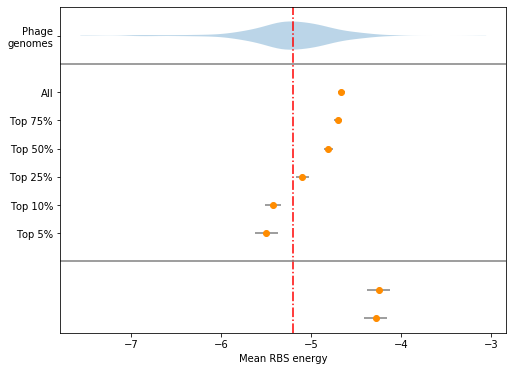

In [72]:
temp_df = combined_df[combined_df['prot_abundance'].isnull()==False]
temp_df = temp_df[temp_df['prot_abundance'] > 0]

col_name = 'RBS_energy'
mean_virus = []
for virus_tsv in glob.glob('../Data/562_rep_viruses/*.clean.tsv')[:]:
    virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
    mean_virus.append(virus_df[col_name].mean())

host_means = []
host_errs = []
for i in [0, 25, 50, 75, 90, 95]:
    percentile_thresh = np.percentile(temp_df['prot_abundance'], i)
    host_means.append(temp_df[temp_df['prot_abundance']>=percentile_thresh][col_name].mean())
    host_errs.append(temp_df[temp_df['prot_abundance']>=percentile_thresh][col_name].std()/
                    np.sqrt(temp_df[temp_df['prot_abundance']>=percentile_thresh].shape[0]))

essentiality_means = []
essentiality_errs = []
essentiality_means.append(combined_df[combined_df['essentiality_a']=='Essential'][col_name].mean())
essentiality_means.append(combined_df[combined_df['essentiality_b']=='Essential'][col_name].mean())
essentiality_errs.append(combined_df[combined_df['essentiality_a']=='Essential'][col_name].std()/\
                        np.sqrt(combined_df[combined_df['essentiality_a']=='Essential'].shape[0]))
essentiality_errs.append(combined_df[combined_df['essentiality_b']=='Essential'][col_name].std()/\
                        np.sqrt(combined_df[combined_df['essentiality_b']=='Essential'].shape[0]))

fig, ax = plt.subplots(figsize=(8,6))
ax.violinplot([mean_virus], widths=0.5, vert=False, showextrema=False, points=100)
ax.axvline(np.median(mean_virus), c='r', linestyle='-.')
ax.axhline(0.5, c='gray')
ax.errorbar(host_means, np.arange(0, -len(host_means)/2, -0.5), xerr=host_errs,\
            marker='o', linestyle='', mfc='darkorange', mec='darkorange', ecolor='gray', zorder=0)
ax.axhline(-3, c='gray')
ax.errorbar(essentiality_means, np.arange(-3.5, -4.5, -0.5), xerr=essentiality_errs,\
            marker='o', linestyle='', mfc='darkorange', mec='darkorange', ecolor='gray', zorder=0)
ax.set_xlabel('Mean RBS energy')
ax.set_yticks([1]+list(np.arange(0, -len(host_means)/2, -0.5)))
ax.set_yticklabels(['Phage\ngenomes',\
                    'All',\
                    'Top 75%',\
                    'Top 50%',\
                    'Top 25%',\
                    'Top 10%',\
                    'Top 5%'])